In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
!ls "/content/gdrive/My Drive"

 AIET_NOTEBOOK_LAB   COLAB  'Colab Notebooks'  'Deep Learning'	'My Stuff'


In [0]:
import os

# os.chdir('gdrive/My Drive/COLAB')  #change dir
# !unzip -q test.zip -d test/  #unzip data in test/

In [20]:
!ls

gdrive	sample_data


In [0]:
# !mkdir cell_images  #create a directory named cell_images/
# !unzip -q cell_images.zip -d cell_images/  #unzip data in cell_images/

In [21]:
# os.chdir('cell_images')
# !ls

print(os.listdir("gdrive/My Drive/COLAB/cell_images/"))

['Parasitized', 'Uninfected']


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [0]:
img_dir='gdrive/My Drive/COLAB/cell_images/'

In [24]:
path=Path(img_dir)
path

PosixPath('gdrive/My Drive/COLAB/cell_images')

In [0]:
data = ImageDataBunch.from_folder(path, train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)

In [26]:
data

ImageDataBunch;

Train: LabelList (22047 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Parasitized,Parasitized,Parasitized,Parasitized,Parasitized
Path: gdrive/My Drive/COLAB/cell_images;

Valid: LabelList (5511 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Parasitized,Uninfected,Parasitized,Parasitized,Parasitized
Path: gdrive/My Drive/COLAB/cell_images;

Test: None

In [27]:
print(f'Classes: \n {data.classes}')


Classes: 
 ['Parasitized', 'Uninfected']


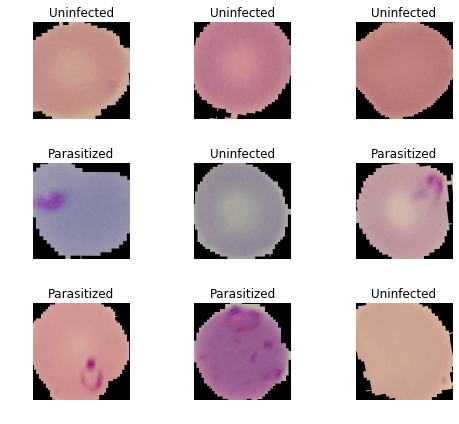

In [28]:
data.show_batch(rows=3, figsize=(7,6))

In [29]:
learn = create_cnn(data, models.resnet101, metrics=accuracy, model_dir="/tmp/model/")

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:11<00:00, 16181818.67it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


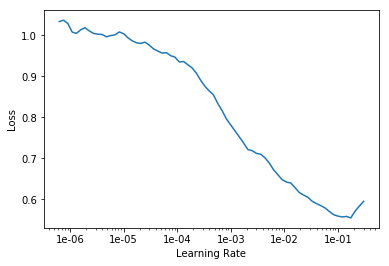

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(6,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.161771,0.141330,0.952459,2:45:30
1,0.186568,0.935427,0.825440,15:16
2,0.142556,0.133863,0.948285,15:20
3,0.130478,0.105608,0.959173,15:17
4,0.103241,0.086240,0.970241,15:27
5,0.089767,0.079147,0.970786,15:26


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


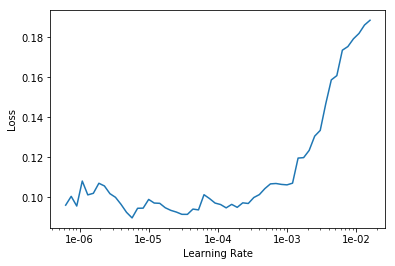

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(4, max_lr=slice(5e-6,5e-5 ))

epoch,train_loss,valid_loss,accuracy,time
0,0.094592,0.078294,0.971149,18:31
1,0.091529,0.077910,0.971512,18:28
2,0.091784,0.077005,0.972419,18:34
3,0.089234,0.075534,0.973145,18:23


In [0]:
learn.save('stage-2')

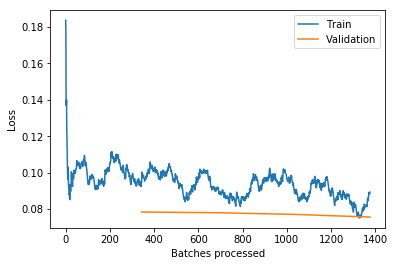

In [37]:
learn.recorder.plot_losses()

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

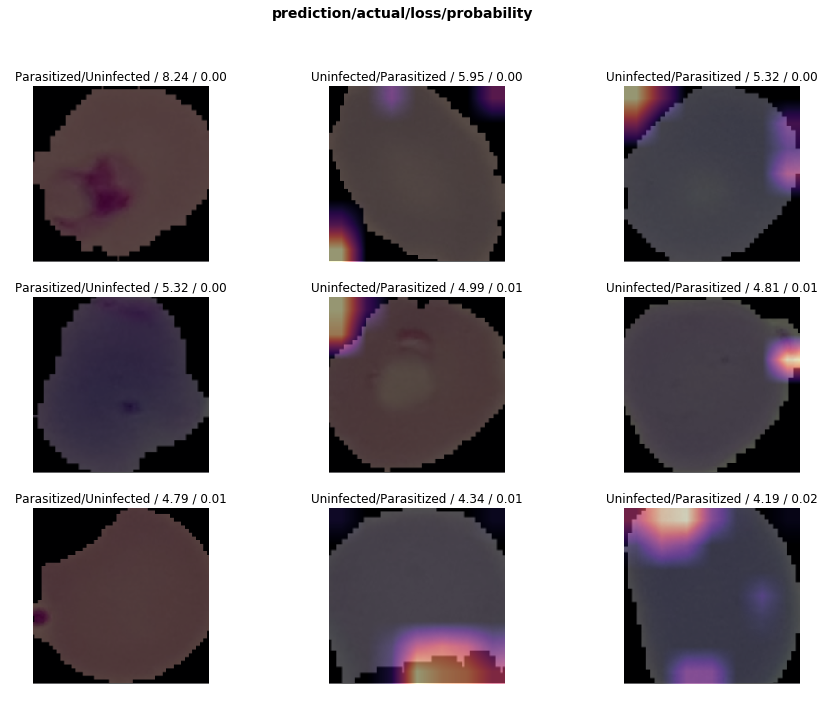

In [39]:
interp.plot_top_losses(9, figsize=(15,11))

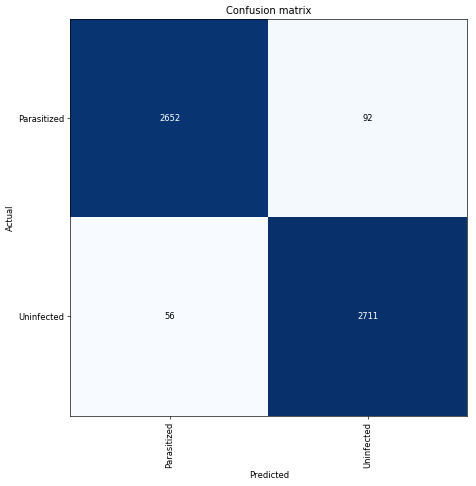

In [40]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [41]:
interp.most_confused(min_val=2)

[('Parasitized', 'Uninfected', 92), ('Uninfected', 'Parasitized', 56)]

In [0]:
pred_data= ImageDataBunch.from_folder(path, train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)

In [43]:
predictor=create_cnn(data, models.resnet101, metrics=accuracy, model_dir="/tmp/model/").load('stage-2')

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [44]:
pred_data.single_from_classes(path, pred_data.classes)

ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: gdrive/My Drive/COLAB/cell_images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: gdrive/My Drive/COLAB/cell_images;

Test: None

Category Parasitized

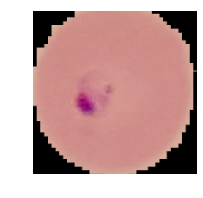

In [45]:
x,y = data.valid_ds[3]
x.show()
data.valid_ds.y[3]

In [46]:
pred_class,pred_idx,outputs = predictor.predict(x)
pred_class

Category Parasitized

In [0]:
def heatMap(x,y,data, learner, size=(0,224,224,0)):
    """HeatMap"""
    
    # Evaluation mode
    m=learner.model.eval()
    
    # Denormalize the image
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    # hook the activations
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(y)].backward()

    # Activations    
    acts=hook_a.stored[0].cpu()
    
    # Avg of the activations
    avg_acts=acts.mean(0)
    
    # Show HeatMap
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(avg_acts, alpha=0.5, extent=size,
              interpolation='bilinear', cmap='magma')

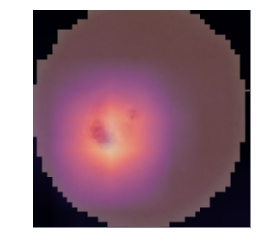

In [48]:
heatMap(x,y,pred_data,learn)